### Seleção dos ZCTAs para Expansão de Laboratórios

Este notebook descreve passo a passo o procedimento adotado para identificar três ZCTAs ideais para a expansão estratégica da rede de laboratórios, seguindo critérios validados por análises anteriores:

1. Identificação das áreas com maior população
    - Selecionar ZCTAs com alta densidade populacional (top 3%), dado que existe correlação significativa entre população e potencial de receita.

2. Exclusão das áreas com renda média-alta (Quartil Q3)
    - Focar nas áreas de baixa renda (Q1), média-baixa renda (Q2) e alta renda (Q4), evitando o Q3 devido ao desempenho inferior comprovado.

3. Aplicação do Indicador de Expansão (expansion_indicator)
    - Calcular e ordenar o indicador específico que prioriza regiões com maior concentração populacional entre 25-54 anos (alta demanda), ponderado pela proporção feminina, garantindo maior retorno potencial.
    - Obs: Cálculo do indicador
        - soma(população entre 25-54)/sex_ratiomalesper100females
        - ou seja, quanto maior a população entre essa faixa e menor o valor de sex_ratiomalesper100females meu indicador é maior, corroborando com as hipóteses de faixa etária e gênero

---

In [85]:
# Importando bibliotecas
import warnings
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [86]:
# Carregando os data sets relacionados
geocode_data = pd.read_csv('../../../data/processed/geocode_data_clean.csv')
economic_data = pd.read_csv('../../../data/processed/economic_data_clean.csv')
demographic_data = pd.read_csv('../../../data/processed/demographic_data_clean.csv')

In [87]:
# 1. Obtendo ZCTAs excluidos de áreas com renda média-alta (Quartil Q3)

# Mapeando faixas de renda para valores numéricos
income_mapping = {
    '< $10.000': 5000,
    '$10.000 - $14.999': 12500,
    '$15.000 - $24.999': 20000,
    '$25.000 - $34.999': 30000,
    '$35.000 - $49.999': 42500,
    '$50.000 - $74.999': 62500,
    '$75.000 - $99.999': 87500,
    '$100.000 - $149.999': 125000,
    '$150.000 - $199.999': 175000,
    '$200.000 >=': 250000 
}

# Adicionando coluna com valor numérico aproximado para cada faixa de renda
economic_data['income_value'] = economic_data['household_range'].map(income_mapping)
weighted_income = economic_data.groupby('zipcode').apply(
    lambda x: sum(x['income_value'] * x['total_households']) / x['total_households'].sum(), include_groups=False
)

weighted_income.head()

zipcode
601    21281.993102
602    26385.792779
603    27007.879135
606    17896.968140
610    28714.042069
dtype: float64

In [88]:
# Transformando em um dataframe
weighted_income_df = weighted_income.reset_index()
weighted_income_df.columns = ['zipcode', 'weighted_avg_income']

# Dividindo em 4 quatis
weighted_income_df['income_quartile'] = pd.qcut(weighted_income_df['weighted_avg_income'], 4, labels=['Q1 (Baixa)', 'Q2 (Média-Baixa)', 'Q3 (Média-Alta)', 'Q4 (Alta)'])

# Excluindo o q3 - média alta
weighted_income_df = weighted_income_df[weighted_income_df['income_quartile'] != 'Q3 (Média-Alta)']
weighted_income_df.head()

,zipcode,weighted_avg_income,income_quartile
0,601,21281.993102,Q1 (Baixa)
1,602,26385.792779,Q1 (Baixa)
2,603,27007.879135,Q1 (Baixa)
3,606,17896.968140,Q1 (Baixa)
4,610,28714.042069,Q1 (Baixa)


In [89]:
# 2. Calculo do Indicador expansion_indicator

# 2.1 - Numerador
# Obter as faixas apenas de interesse
ages_groups_prioritis = ['25 - 34 Years', '35 - 44 Years', '45 - 54 Years']
demo_ages_groups_priority = demographic_data[demographic_data['age_group'].isin(ages_groups_prioritis)]

demo_ages_groups_priority.head()

,id,zipcode,total_population,sex_ratiomalesper100females,median_age_in_years,age_group,group_population
147640,8600000US35004,35004,12045,94.1,35.5,25 - 34 Years,2088
147641,8600000US35005,35005,7344,86.1,44.0,25 - 34 Years,788
147642,8600000US35006,35006,2883,108.2,47.2,25 - 34 Years,183
147643,8600000US35007,35007,26332,95.0,37.7,25 - 34 Years,3119
147644,8600000US35010,35010,20613,90.5,42.6,25 - 34 Years,2513


In [90]:
# group_population somado é o numerador do expansion_indicator
age_indicator = demo_ages_groups_priority.groupby('zipcode').agg({
    'total_population': 'first',
    'sex_ratiomalesper100females': 'first',
    'median_age_in_years': 'first',
    'group_population': 'sum'
}).reset_index()

age_indicator.head()

,zipcode,total_population,sex_ratiomalesper100females,median_age_in_years,group_population
0,601,17113,99.5,41.9,6427
1,602,37751,96.0,42.9,14726
2,603,47081,96.5,42.1,17496
3,606,6392,100.3,44.3,2349
4,610,26686,93.9,42.7,10337


In [91]:
# 3. Filtrando pelos top 3% zipcodes em população

top_3_population = age_indicator['total_population'] > age_indicator['total_population'].quantile(0.97)
age_indicator_top3 = age_indicator[top_3_population]

age_indicator_top3.head()

,zipcode,total_population,sex_ratiomalesper100females,median_age_in_years,group_population
5,612,59369,89.3,42.6,21861
41,693,53360,91.9,41.4,20225
56,725,80537,84.4,41.9,30251
57,727,52743,91.2,40.8,21619
59,729,51015,91.6,40.1,20598


In [92]:
# Adicionando quartil de renda
age_indicator_top3_income = age_indicator_top3.merge(weighted_income_df, on='zipcode', how='left')

age_indicator_top3_income['income_quartile'].value_counts()

income_quartile
Q4 (Alta)           370
Q2 (Média-Baixa)    150
Q1 (Baixa)          117
Q3 (Média-Alta)       0
Name: count, dtype: int64

In [93]:
# Criando funções e constante para normalizar os critérios para o expansion_indicator

min_ai = min(age_indicator['group_population'])
max_ai = max(age_indicator['group_population'])

min_sr = min(age_indicator['sex_ratiomalesper100females'])
max_sr = max(age_indicator['sex_ratiomalesper100females'])

def normalize(x, min_x, max_x):
    """
    Normaliza os dados entre 0 e 1
    """
    return (x - min_x) / (max_x - min_x)

In [94]:
# Aplicando o indicador normalizado

age_indicator_top3_income.loc[:, 'expansion_indicator'] = (normalize(age_indicator_top3_income['group_population'], min_ai, max_ai) / normalize(age_indicator_top3_income['sex_ratiomalesper100females'], min_sr, max_sr))

In [95]:
# Ordenando pelo indicador, filtrado pelo top 3 e obtendo as colunas de interesse
final_result = age_indicator_top3_income.sort_values(by='expansion_indicator', ascending=False).head(3)[['zipcode', 'total_population', 'sex_ratiomalesper100females', 'group_population', 'income_quartile']]

### **Vizualisando os resultados**

In [96]:
final_result

,zipcode,total_population,sex_ratiomalesper100females,group_population,income_quartile
88,11212,75605,71.2,32747,Q1 (Baixa)
105,11236,100844,77.0,40816,Q4 (Alta)
58,10128,58636,75.0,29326,Q4 (Alta)


In [97]:
print('Os ZCTAs escolhidos para expansão foram:')
for zipcode in final_result['zipcode'].unique():
    print(f'- {zipcode}')

Os ZCTAs escolhidos para expansão foram:
- 11212
- 11236
- 10128


#### Vizualizando os valores dos critérios escolhidos em relação ao todo

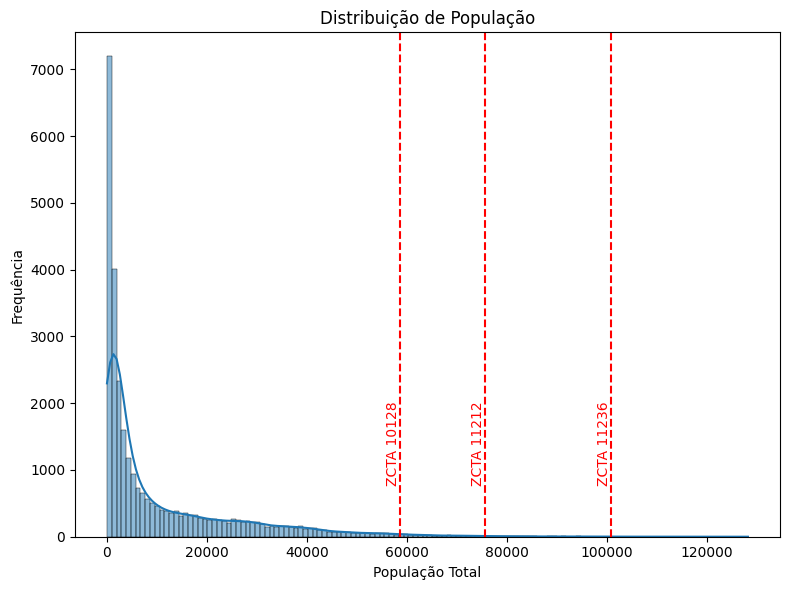

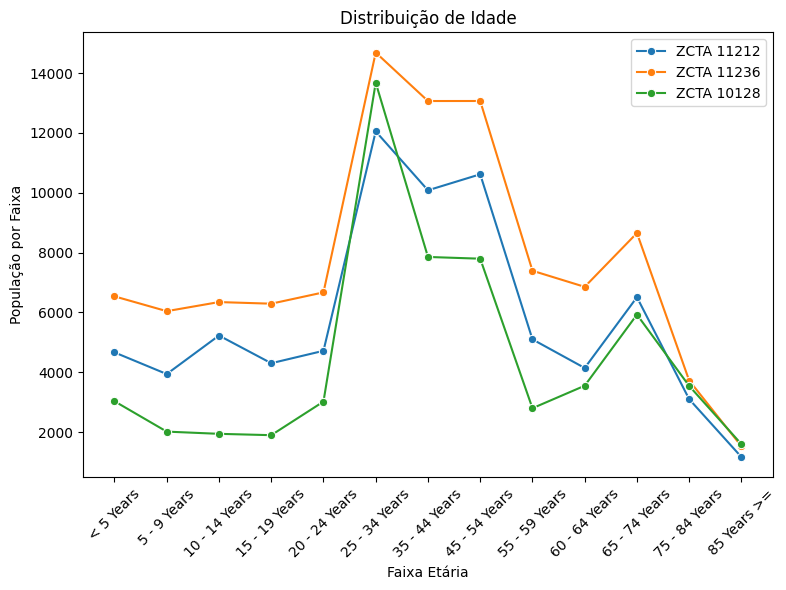

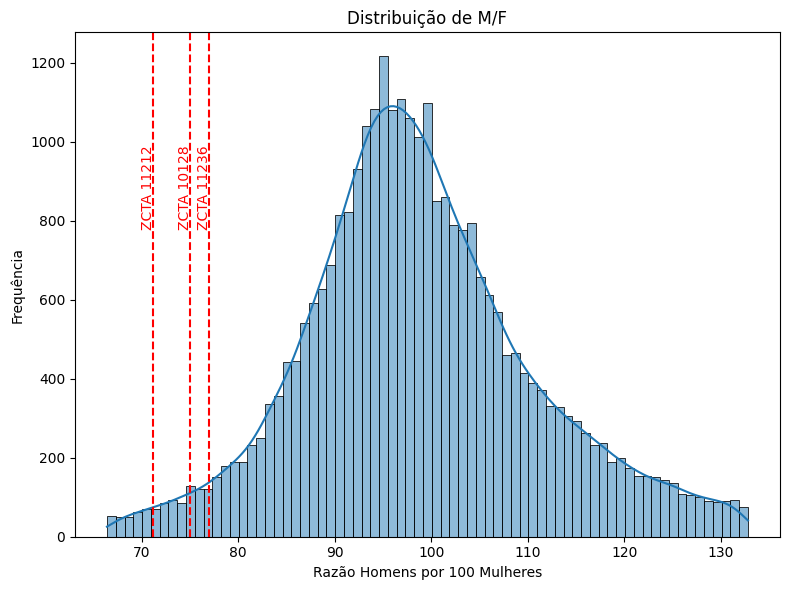

In [98]:

# Obtendo a população por ZCTA
demographic_population = demographic_data.groupby('zipcode').agg({
    'total_population': 'first',
}).reset_index()

# Obtendo o sex_ratiomalesper100females por ZCTA
demographic_female = demographic_data.groupby('zipcode').agg({
    'sex_ratiomalesper100females': 'first',
}).reset_index()

final_zipcodes = final_result['zipcode'].unique()

# Distribuição de População
plt.figure(figsize=(8, 6))
sns.histplot(
    data=demographic_population,
    x='total_population',
    kde=True
)
plt.title('Distribuição de População')
plt.xlabel('População Total')
plt.ylabel('Frequência')

for z in final_zipcodes:
    pop_val = demographic_population.loc[
        demographic_population['zipcode'] == z,
        'total_population'
    ].values[0]
    plt.axvline(pop_val, color='red', linestyle='--')
    plt.text(
        x=pop_val,
        y=plt.gca().get_ylim()[1]*0.1,
        s=f'ZCTA {z}',
        color='red',
        rotation=90,
        ha='right',
        va='bottom'
    )
plt.tight_layout()
plt.show()

# Distribuição de Idade
plt.figure(figsize=(8, 6))
for z in final_zipcodes:
    subset = demographic_data[demographic_data['zipcode'] == z].copy()
    sns.lineplot(
        data=subset,
        x='age_group',
        y='group_population',
        marker='o',
        label=f'ZCTA {z}'
    )

plt.title('Distribuição de Idade')
plt.xlabel('Faixa Etária')
plt.ylabel('População por Faixa')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Distribuição de M/F
plt.figure(figsize=(8, 6))
sns.histplot(
    data=demographic_female,
    x='sex_ratiomalesper100females',
    kde=True
)
plt.title('Distribuição de M/F')
plt.xlabel('Razão Homens por 100 Mulheres')
plt.ylabel('Frequência')

for z in final_zipcodes:
    ratio_val = demographic_female.loc[
        demographic_female['zipcode'] == z,
        'sex_ratiomalesper100females'
    ].values[0]
    plt.axvline(ratio_val, color='red', linestyle='--')
    y_pos = plt.gca().get_ylim()[1] - 500
    plt.text(
        x=ratio_val - 0.5,
        y=y_pos,
        s=f'ZCTA {z}',
        color='red',
        rotation=90,
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()



---

# Conclusão

Com base nas análises realizadas e representadas nos gráficos fornecidos, os critérios adotados para a seleção dos três ZCTAs ideais **(11212, 11236 e 10128)** mostraram-se bem fundamentados e alinhados à estratégia de expansão da rede de laboratórios.

**1. População**
- O primeiro gráfico evidencia claramente a relevância da densidade populacional como critério, com os ZCTAs escolhidos posicionados significativamente acima da média geral, indicando alta probabilidade de gerar um maior volume de exames e receita.

**2. Idade**
- No segundo gráfico, a distribuição etária valida a importância de considerar áreas com grande concentração na faixa etária (25-54 anos), com uma tendência clara de alta demanda por exames diagnósticos nessa faixa específica, especialmente relevante nos ZCTAs escolhidos. O indicador de expansão aplicado reforçou justamente a importância dessa concentração etária, confirmando a metodológica adotada.

**3. Gênero**
- O terceiro gráfico valida o critério do gênero, mostrando que os ZCTAs selecionados possuem uma proporção favorável de mulheres em relação aos homens, alinhado à hipótese de que áreas com maior presença feminina são mais promissoras para a frequência e volume de exames.

Contudo, apesar da eficácia demonstrada, é importante reconhecer algumas limitações dessa metodologia. Uma delas é a ausência de uma avaliação detalhada sobre a densidade competitiva atual em cada ZCTA, o que poderia impactar significativamente o sucesso da expansão. Além disso, a análise não contempla variáveis qualitativas como comportamento de consumo, percepção local sobre serviços de saúde ou acessibilidade geográfica.